###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1337)
random.seed(1337)

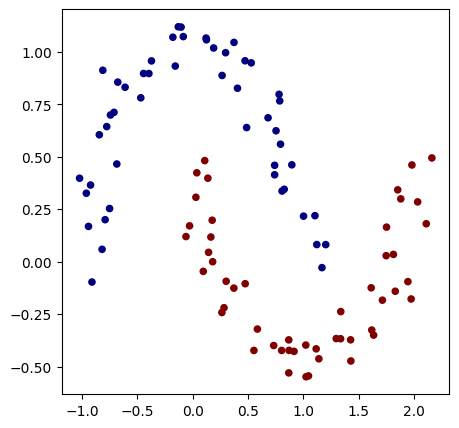

In [3]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [4]:
def unfrozen_info(model):
    fls = [(lid, l) for lid, l in enumerate(model.layers) if not l.frozen]
    if len(fls) == 0:
        return
    params = [(id, n) for id, n in enumerate(fls[0][1].parameters())]
    params = [(fls[0][0], id, p.grad, p.learning_rate, p.learning_rate * p.grad) for id, p in params if p.learning_rate > 0.0]
    params.sort(key=lambda p: p[1])
    return params

In [5]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

# initialize a model
model = MLP(2, [8, 32, 8, 1], act='tanh') # 1-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2)], Layer of [tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8)], Layer of [tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32)], Layer of [linear-Neuron(8)]]
number of parameters 585


In [6]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc, len(model.parameters()))

Value(data=2.5973877096400817, grad=0.0, lr=1.0) 0.22 585


In [7]:
# optimization
for k in range(5):

    # forward
    total_loss, acc = loss()
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    # learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.learn(0.5)

    # if model.freeze():
    #    print('Early Stop by FREEZE!')
    #    break

total_loss, acc = loss()
model.zero_grad()
total_loss.backward()
print(f"final loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 2.5973877096400817, accuracy 22.0%
step 1 loss 0.5994416765665168, accuracy 84.0%
step 2 loss 0.8090818066398242, accuracy 81.0%
step 3 loss 0.428039001810272, accuracy 83.0%
step 4 loss 0.46053310705346023, accuracy 85.0%
final loss 0.39239876902978205, accuracy 86.0%


In [31]:
parameters = model.parameters()
parameters.sort(key=lambda v: abs(v.grad))
[p.grad for p in parameters][-1::-1]

[-0.06428393658959244,
 -0.052078853856302225,
 -0.051702116260179835,
 0.0491951775448579,
 0.047162099495240875,
 -0.046363993126114,
 0.04591967036113923,
 -0.043852051116633144,
 0.04344495094693231,
 0.042908989115645835,
 -0.041930156146780063,
 0.040052745641774884,
 0.0398847100896013,
 0.03837524710793472,
 0.035908964477890264,
 -0.035143269838815924,
 0.03470481912434308,
 0.03424633649265085,
 -0.032605723131171514,
 0.026571006015396706,
 -0.026103696589712025,
 -0.02431618987617528,
 -0.02322284852478478,
 0.021818908757854086,
 0.021792836528757267,
 -0.021577358922112922,
 0.019763238773103688,
 0.018480316584086644,
 0.01738365182597821,
 -0.016850154072934723,
 0.014782116468089437,
 0.014675422790121372,
 0.013609965605080935,
 0.013249842030354725,
 0.01194344877283696,
 -0.011716457808279545,
 -0.010709170688179028,
 -0.010538660573923681,
 -0.010515878239211615,
 0.010337314851321071,
 -0.010029652206905867,
 -0.009956995284546405,
 0.009822539591361286,
 0.009764

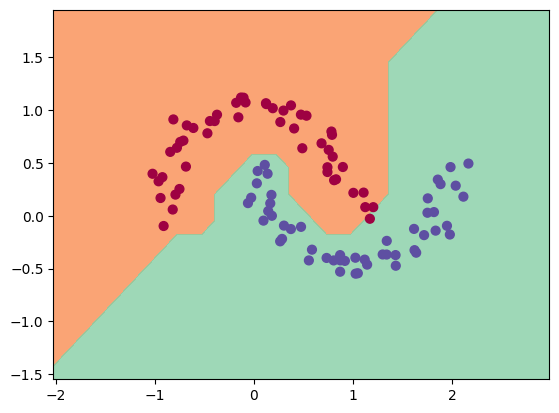

In [32]:
# visualize decision boundary
def visual():
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

visual()

# tanh

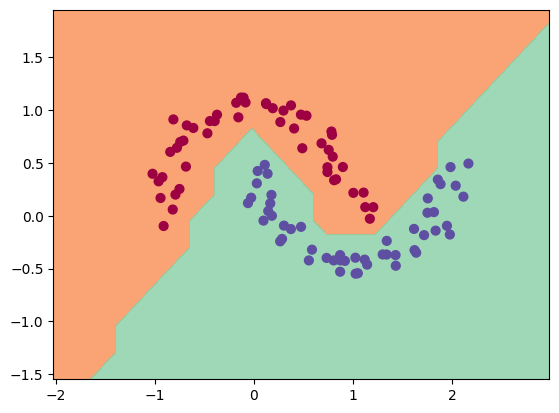

In [8]:
visual()

# relu

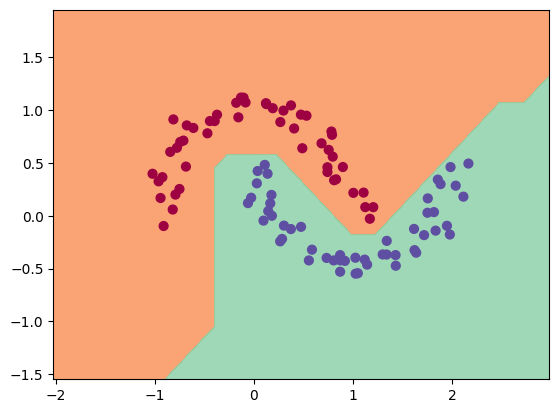

In [12]:
visual()

# tanh with dynamic learning rate <0.5, 1.1>

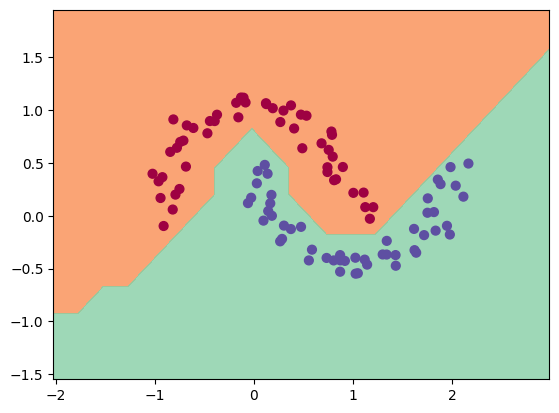

In [8]:
visual()

# relu with dynamic learning rate <0.5, 1.1>

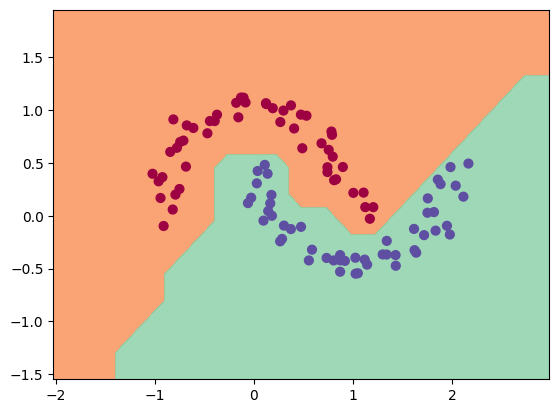

In [22]:
visual()